In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import SimpleITK as sitk
from ipywidgets import interact, fixed
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
def start_plot():
    global metric_values, multires_iterations
    metric_values = []
    multires_iterations = []
# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()

In [28]:
fanimal = 'DK52'
manimal = 'DK39'
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data'
MOVING = os.path.join(DIR, manimal, 'preps', 'CH1', 'thumbnail_aligned')
FIXED = os.path.join(DIR, fanimal, 'preps', 'CH1', 'thumbnail_aligned')

In [31]:
images = []
files = os.listdir(MOVING)
for file in tqdm(files):
    tif = io.imread(os.path.join(MOVING, file))
    images.append(tif)
moving_volume = np.array(images).astype('uint8')
del images

100%|██████████| 469/469 [00:05<00:00, 87.88it/s]


In [32]:
images = []
files = os.listdir(FIXED)
for file in tqdm(files):
    tif = io.imread(os.path.join(FIXED, file))
    images.append(tif)
fixed_volume = np.array(images).astype('uint8')
del images

100%|██████████| 486/486 [00:33<00:00, 14.41it/s]


In [38]:
fixed_files = []
files = os.listdir(FIXED)
for file in tqdm(files):
    tif = os.path.join(FIXED, file)
    fixed_files.append(tif)
moving_files = []
files = os.listdir(MOVING)
for file in tqdm(files):
    tif = os.path.join(MOVING, file)
    moving_files.append(tif)


100%|██████████| 469/469 [00:00<00:00, 379242.06it/s]


In [47]:
moving_files = moving_files[0:len(fixed_files)]

In [48]:
moving_images = sitk.ReadImage(moving_files, sitk.sitkUInt16)
fixed_images =  sitk.ReadImage(fixed_files, sitk.sitkUInt16)

In [50]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_images,
    moving_images,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY)

In [ ]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                  numberOfIterations=100, 
                                                  convergenceMinimumValue=1e-6, 
                                                  convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_images, sitk.sitkFloat32), 
                                               sitk.Cast(moving_images, sitk.sitkFloat32))

In [15]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.5408137650836468
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 14.


In [16]:
moving_resampled = sitk.Resample(
    moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())


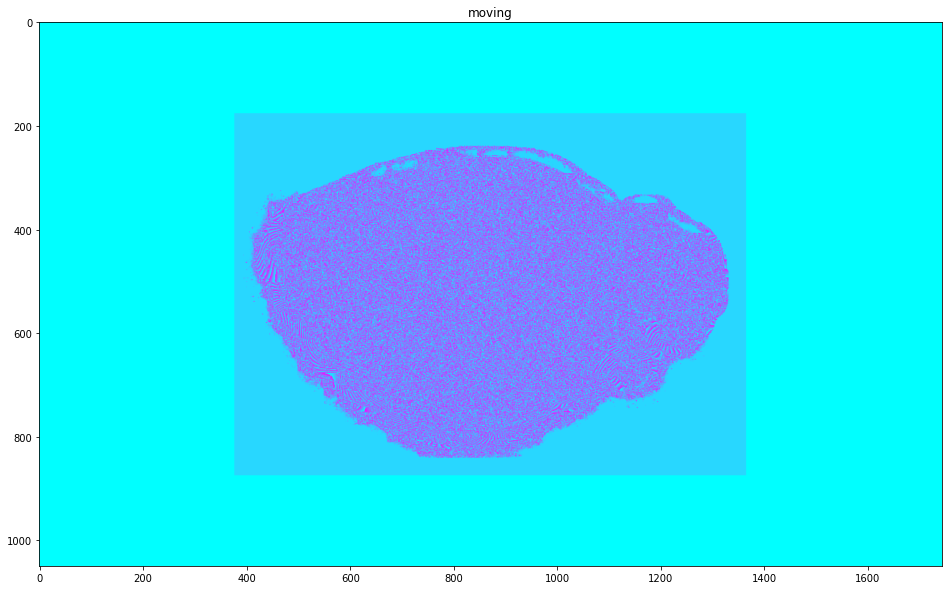

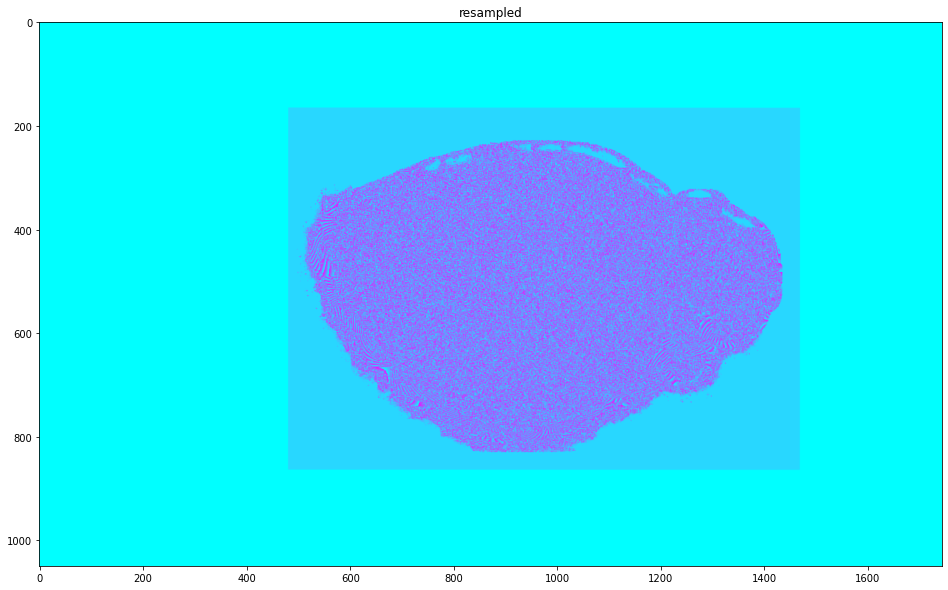

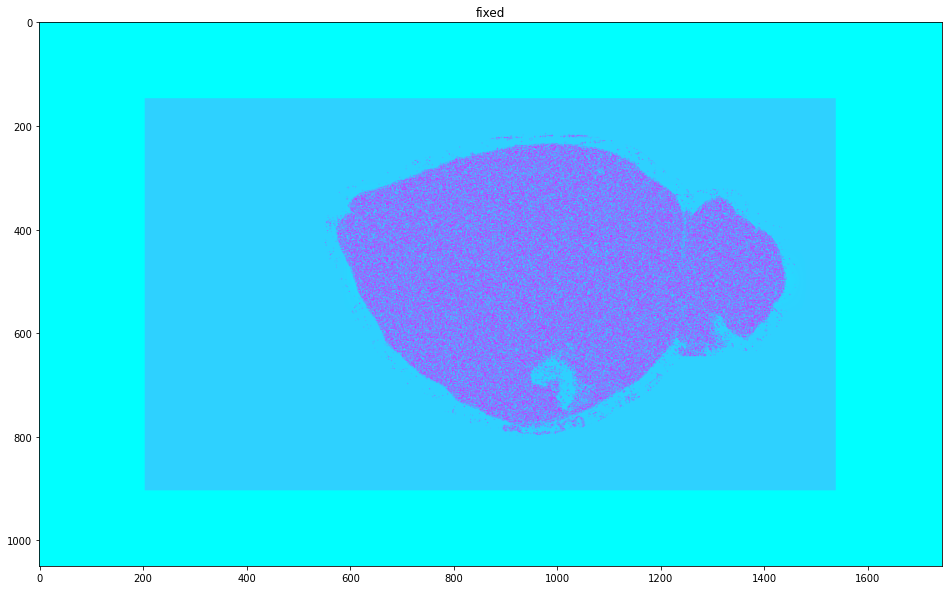

In [24]:
images = [moving_image, moving_resampled, fixed_image]
names = ['moving', 'resampled', 'fixed']
for img, name in zip(images, names):
    plt.figure(figsize=(20,10))
    plt.title(name)
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap='cool')
    